In [2]:
import numpy as np
from math import floor, pi, sqrt, asin
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    """
    Marks |target> with a phase (-1). qiskit bitstring ordering: qc.measure returns MSB..LSB,
    but internal indexing used here assumes qr[0] is LSB, so we reverse the formatted bitstring.
    """
    n = len(qr)
    bitstr = format(target, f"0{n}b")[::-1]  # reversed: q[0] is LSB in qiskit ordering
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]
    # flip zeros to ones so that multi-controlled Z targets the all-ones state
    for i in zero_positions:
        qc.x(qr[i])
    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    # undo the Xs
    for i in zero_positions:
        qc.x(qr[i])

def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    """
    Standard Grover diffusion operator (inversion about the mean).
    """
    n = len(qr)
    qc.h(qr)
    qc.x(qr)

    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)

    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int = None):
    """
    Build a Grover quantum circuit for given number of qubits `n` and integer target.
    If iterations is None, uses the (pi/4)*sqrt(N) heuristic (at least 1 iteration).
    Returns (qc, r_used) where r_used is the number of Grover iterations applied.
    """
    if target < 0 or target >= 2**n:
        raise ValueError("target must be in range [0, 2^n - 1]")
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    qc.h(qr)  # uniform superposition
    N = 2**n
    if iterations is None:
        r = max(1, int(floor((pi / 4) * sqrt(N))))
    else:
        r = int(iterations)
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    qc.measure(qr, cr)
    return qc, r

def run_and_plot(qc: QuantumCircuit, shots: int = 1024, show_circuit: bool = True):
    """
    Transpile & run a prepared circuit on AerSimulator, show the circuit (optional),
    return counts and show histogram.
    """
    backend = AerSimulator()
    if show_circuit:
        fig = qc.draw(output="mpl", idle_wires=False)
        plt.show(fig)
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print("Counts:", counts)
    plot_histogram(counts)
    plt.show()
    most_likely = max(counts, key=counts.get)
    print(f"Most likely measured state: {most_likely}  (string shown MSB...LSB)")
    return counts

def theoretical_probability(N: int, r: int) -> float:
    """
    Analytical Grover success probability after r iterations for single marked element in N states.
    """
    theta = asin(1.0 / sqrt(N))
    return np.sin((2 * r + 1) * theta) ** 2


In [3]:
# Activity 1
def run_grover_2qubit(target_binary: str = "10", shots: int = 1024, show_circuit: bool = True):
    """
    Run a single Grover iteration on 2 qubits to search for `target_binary` (e.g. '10').
    """
    if len(target_binary) != 2 or any(c not in "01" for c in target_binary):
        raise ValueError("target_binary must be a 2-character string of '0'/'1', e.g. '10'")
    target_int = int(target_binary, 2)
    n = 2
    iterations = 1  # exactly one iteration as requested
    qc, r_used = build_grover_circuit(n, target_int, iterations)
    print(f"Running Grover (n={n}) searching for |{target_binary}> (int {target_int}), iterations={r_used}")
    counts = run_and_plot(qc, shots=shots, show_circuit=show_circuit)
    return counts

if __name__ == "__main__":
    run_grover_2qubit("10", shots=1024)


Running Grover (n=2) searching for |10> (int 2), iterations=1
Counts: {'10': 1024}
Most likely measured state: 10  (string shown MSB...LSB)


Scanning r = 1..20 for target |101> (int 5), shots=1024
r= 1  empirical=0.8008 (820/1024)  theoretical=0.7812
r= 2  empirical=0.9521 (975/1024)  theoretical=0.9453
r= 3  empirical=0.3154 (323/1024)  theoretical=0.3301
r= 4  empirical=0.0117 (12/1024)  theoretical=0.0122
r= 5  empirical=0.5449 (558/1024)  theoretical=0.5480
r= 6  empirical=1.0000 (1024/1024)  theoretical=0.9998
r= 7  empirical=0.5801 (594/1024)  theoretical=0.5770
r= 8  empirical=0.0225 (23/1024)  theoretical=0.0195
r= 9  empirical=0.3135 (321/1024)  theoretical=0.3029
r=10  empirical=0.9375 (960/1024)  theoretical=0.9313
r=11  empirical=0.8154 (835/1024)  theoretical=0.8049
r=12  empirical=0.1396 (143/1024)  theoretical=0.1450
r=13  empirical=0.1162 (119/1024)  theoretical=0.1063
r=14  empirical=0.7539 (772/1024)  theoretical=0.7566
r=15  empirical=0.9639 (987/1024)  theoretical=0.9578
r=16  empirical=0.3438 (352/1024)  theoretical=0.3578
r=17  empirical=0.0078 (8/1024)  theoretical=0.0066
r=18  empirical=0.5068 (519/1

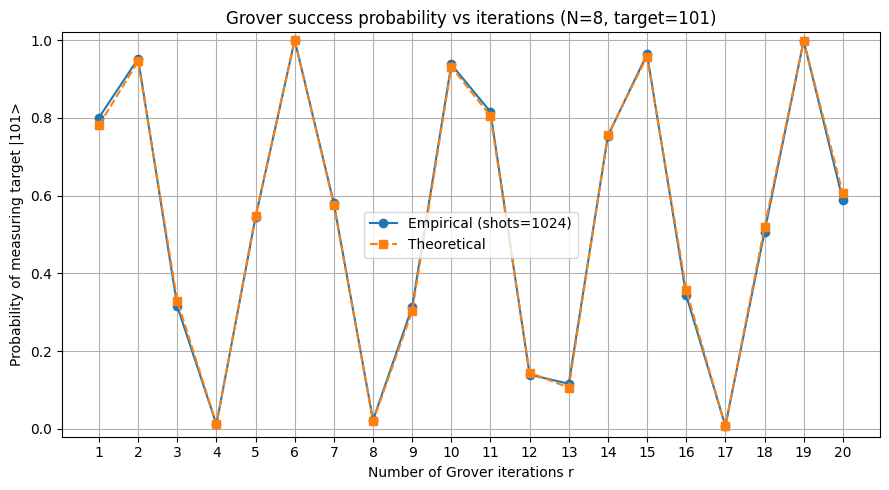

Best empirical r = 6 with empirical prob 1.0000
Counts: {'101': 1024}
Most likely measured state: 101  (string shown MSB...LSB)


In [6]:
# Activity 2
def run_grover_3qubit_scan(target_binary: str = "101", r_max: int = 20, shots: int = 1024):
    """
    For n=3, run Grover for r in 1..r_max, collect empirical success probabilities,
    compare to theory, and show a best-r histogram.
    """
    target_int = int(target_binary, 2)
    N = 2 ** 3
    backend = AerSimulator()

    rs = list(range(1, r_max + 1))
    empirical_probs = []
    theoretical_probs = []

    print(f"Scanning r = 1..{r_max} for target |{target_binary}> (int {target_int}), shots={shots}")
    for r in rs:
        qc, _ = build_grover_circuit(3, target_int, iterations=r)
        compiled = transpile(qc, backend)
        job = backend.run(compiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        success_counts = counts.get(target_binary, 0)
        p_emp = success_counts / shots
        p_theo = theoretical_probability(N, r)
        empirical_probs.append(p_emp)
        theoretical_probs.append(p_theo)
        print(f"r={r:2d}  empirical={p_emp:.4f} ({success_counts}/{shots})  theoretical={p_theo:.4f}")

    plt.figure(figsize=(9, 5))
    plt.plot(rs, empirical_probs, 'o-', label='Empirical (shots={})'.format(shots))
    plt.plot(rs, theoretical_probs, 's--', label='Theoretical')
    plt.xlabel('Number of Grover iterations r')
    plt.ylabel(f'Probability of measuring target |{target_binary}>')
    plt.title(f'Grover success probability vs iterations (N=8, target={target_binary})')
    plt.xticks(rs)
    plt.ylim(-0.02, 1.02)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    best_r_emp = rs[int(np.argmax(empirical_probs))]
    print(f"Best empirical r = {best_r_emp} with empirical prob {max(empirical_probs):.4f}")
    qc_best, _ = build_grover_circuit(3, target_int, iterations=best_r_emp)
    counts_best = run_and_plot(qc_best, shots=shots)
    return rs, empirical_probs, theoretical_probs, best_r_emp, counts_best

if __name__ == "__main__":
    run_grover_3qubit_scan(target_binary="101", r_max=20, shots=1024)
